In [ ]:

#Installing all necessary packages 
!pip install snowflake-connector-python[pandas]
!pip install holidays
!pip install --upgrade snowflake-sqlalchemy
!pip install imblearn
!pip install catboost
!pip install probatus
from probatus.feature_elimination import ShapRFECV
!pip install tensorflow
!pip install ipywidgets
!pip install pandas_profiling
!pip install optuna


import optuna
from sklearn.metrics import mean_squared_error
from pandas_profiling import ProfileReport
import snowflake.connector
import numpy as np
import pandas as pd
import datetime as dt
import boto3
import base64
from numpy import dtype, isnan, sqrt
from sqlalchemy import create_engine
from sqlalchemy import pool
from sqlalchemy.dialects import registry
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.asymmetric import rsa
from cryptography.hazmat.primitives.asymmetric import dsa
from cryptography.hazmat.primitives import serialization
from botocore.exceptions import ClientError
from snowflake.connector.pandas_tools import write_pandas, pd_writer
from dateutil.easter import *
from pathlib import Path
from imblearn.over_sampling import SMOTE
import gc
import dask.dataframe as dd
import dask
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
import catboost
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, log_loss
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC


import seaborn as sns
import shap
from catboost import CatBoostClassifier



!jupyter nbextension enable --py widgetsnbextension

%matplotlib inline

In [2]:
# loading datasets
df = pd.read_csv('miq_270922.csv')
df.head()

Columns (5,345,350,351,354,355,356,359,360) have mixed types.Specify dtype option on import or set low_memory=False.


user_id                               view_id  view_order  \
0  K4DQ-2A_00092_0  544789bb-1df8-42c1-a9ce-a5f6c41e04d6         0.0   
1  K4DQ-2A_00095_0  bd3ff415-5c2c-4dfe-832b-783d49980c54         0.0   
2  K4DQ-2A_00096_0  ac565452-8a32-4431-a4eb-9ea9c5974ecb         0.0   
3  K4DQ-2A_00096_0  ac565452-8a32-4431-a4eb-9ea9c5974ecb         0.0   
4  K4DQ-2A_00096_0  ac565452-8a32-4431-a4eb-9ea9c5974ecb         0.0   

        panel_respondent_id     brand brand.1 context_platform ad_type  \
0  5e4550b378980e000191620f       8x4     NaN         facebook   video   
1  5e454f2478980e000191415f       8x4     NaN         facebook   video   
2  5e46cf0ac8170f00012d7cc1  Airwaves     NaN         facebook   video   
3  5e46cf0ac8170f00012d7cc1  Airwaves     NaN         facebook   video   
4  5e46cf0ac8170f00012d7cc1  Airwaves     NaN         facebook   video   

   utc_session_start_time  session_start_time  ... postcode group_id  \
0            1.581605e+12        1.581609e+12  ...      NaN  K4DQ-2A   
1            1.581623e+12        1.581627e+12  ...      NaN  K4DQ-2A   
2            1.582742e+12        1.582745e+12  ...      NaN  K4DQ-2A   
3            1.582742e+12        1.582745e+12  ...      NaN  K4DQ-2A   
4            1.582742e+12        1.582745e+12  ...      NaN  K4DQ-2A   

   session_year  context_ad_id  iab_categories  aspect_ratio  \
0          2020            NaN             NaN           NaN   
1          2020            NaN             NaN           NaN   
2          2020            NaN             NaN           NaN   
3          2020            NaN             NaN           NaN   
4          2020            NaN             NaN           NaN   

   vertical_scroll_deviation  hashed_email  ad_description  video_placement  
0                        NaN           NaN             NaN              NaN  
1                        NaN           NaN             NaN              NaN  
2                        NaN           NaN             NaN              NaN  
3                        NaN           NaN             NaN              NaN  
4                        NaN           NaN             NaN              NaN  

[5 rows x 361 columns]

In [3]:
# x = list(df.columns)

# colnames = pd.DataFrame(x)
# colnames.to_csv("colnames.csv")
df.info()
df.user_id.value_counts()
df.group_id.value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203088 entries, 0 to 203087
Columns: 361 entries, user_id to video_placement
dtypes: bool(2), float64(332), int64(6), object(21)
memory usage: 556.6+ MB


C7AU-62-0122-LINEARTV                        20951
FINE-29-1121-BVODTV                          13044
YAHO-85-0422-CAN-STYLE-ENTERTAINMENT-ITW      5818
YAHO-73-0422-USA-SPORTS-FANTASYSPORTS-ITW     5771
C9AU-26-1021-BVODTV                           4952
                                             ...  
AUST-22-STORIES                                 85
TWIT-36-1221-UK-TWITTER-INSTAGRAM               79
TWIT-51-1221-FRA-TWITTER-TIKTOK                 46
TWIT-60-1221-MEX-TWITTER-INSTAGRAM              32
REDC-67-0122-IRL-INSTAGRAM-STORIES              26
Name: group_id, Length: 134, dtype: int64

In [4]:
df = df[['user_id','ad_type', 'session_start_time_label', 'orientation', 'max_height', 'is_using_headphones', \
         'max_width','platformFormat', 'gender', 'age', 'country', 'ad_length_seconds',\
        'ethnicity','session_year' ,'aspect_ratio', 'video_placement', \
        'active_attentive_seconds', 'passive_attentive_seconds', 'max_continuous_attentive_seconds', 'attention_score_avg']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203088 entries, 0 to 203087
Data columns (total 20 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           203088 non-null  object 
 1   ad_type                           203088 non-null  object 
 2   session_start_time_label          193713 non-null  object 
 3   orientation                       203088 non-null  object 
 4   max_height                        203088 non-null  float64
 5   is_using_headphones               203088 non-null  bool   
 6   max_width                         203088 non-null  float64
 7   platformFormat                    203088 non-null  object 
 8   gender                            202892 non-null  object 
 9   age                               201109 non-null  float64
 10  country                           196952 non-null  object 
 11  ad_length_seconds                 148701 non-null  f

In [5]:
df.is_using_headphones.value_counts()
df.platformFormat.value_counts()

yahoo_native-stream_static_inthewild    58700
linear_tv_lte_15_seconds                16350
ctv_lte_15_seconds                      15965
facebook_in_feed_image                  10903
ctv_30_seconds                          10681
yahoo_display_mrec_inthewild             9802
yahoo_native-moment_static_inthewild     9469
yahoo_pencil_inthewild                   9068
linear_tv_30_seconds                     8262
facebook_in_feed_video                   7443
yahoo_display_wfpad_inthewild            6215
twitter_in_feed_card                     5379
ctv_20_seconds                           4417
yahoo_native-stream_static_intercept     4255
youtube_skippable_gt_15                  3652
instagram_in_feed_video                  3111
youtube_nonskippable_lte_15              3028
bvod_mobile_lte_15_seconds               1919
twitter_in_feed_video                    1679
yahoo_native-pre-roll_inthewild          1276
youtube_skippable_lte_15                 1165
facebook_in_stream                

In [6]:



print(pd.unique(df['ad_type']))


['video' 'static']


In [8]:
# print(pd.unique(df['video_placement']))
# print(pd.unique(df['aspect_ratio']))
# print(pd.unique(df['ethnicity']))
#print(pd.unique(df['country']))


In [7]:
df = df[(df.ad_type == "video")]
#df = df[(df.country == "AU")]


In [8]:
df.describe()

max_height     max_width          age  ad_length_seconds  \
count  86340.000000  86340.000000  85058.00000       85064.000000   
mean     610.963196    999.197243     37.50609          19.835500   
std      355.873256    673.615134     11.03169          22.109601   
min       76.000000    164.000000    -22.00000           0.000000   
25%      320.000000    414.000000     29.00000          15.000000   
50%      387.000000    568.000000     37.00000          15.000000   
75%     1080.000000   1920.000000     45.00000          30.000000   
max     1190.000000   1920.000000     90.00000        3304.000000   

       session_year  active_attentive_seconds  passive_attentive_seconds  \
count  86340.000000              86340.000000               86340.000000   
mean    2020.874276                  6.719504                   7.268045   
std        1.906057                  8.925173                   9.049161   
min     1970.000000                  0.000000                   0.000000   
25%     2020.000000                  0.000000                   0.000000   
50%     2021.000000                  2.000000                   3.000000   
75%     2022.000000                 12.000000                  13.000000   
max     2022.000000                489.000000                 508.000000   

       max_continuous_attentive_seconds  attention_score_avg  
count                      86340.000000         86340.000000  
mean                          13.444058            66.271278  
std                           10.327801            26.766841  
min                            0.000000             0.000000  
25%                            4.000000            50.670000  
50%                           15.000000            68.180000  
75%                           17.000000            88.652500  
max                          244.000000           100.000000

In [9]:
#aspect ratio 
null_vals = df.isnull().sum().apply(lambda x: x * 100 / df.shape[0]).sort_values(ascending = False).loc[lambda x: x > 0]
null_vals

video_placement             91.831133
aspect_ratio                43.912439
ethnicity                   39.087329
session_start_time_label     8.512856
country                      7.106787
age                          1.484827
ad_length_seconds            1.477878
gender                       0.066018
dtype: float64

In [10]:




%%time

df = df.drop(['ethnicity','video_placement', 'gender'], axis=1)



# dfDummies = pd.get_dummies(df)

# plt.figure(figsize=(14,12))
# sns.heatmap(dfDummies.corr(),linewidths=.1,cmap="YlGnBu", annot=True)
# plt.yticks(rotation=0);
# df[df.select_dtypes(['object']).columns] = df.select_dtypes(['object']).apply(lambda x: x.astype('str'))
# df[df.select_dtypes(['float64']).columns] = df.select_dtypes(['float64']).apply(lambda x: x.astype('str'))


CPU times: user 8.4 ms, sys: 0 ns, total: 8.4 ms
Wall time: 7.41 ms


In [11]:
null_vals = df.isnull().sum().apply(lambda x: x * 100 / df.shape[0]).sort_values(ascending = False).loc[lambda x: x > 0]
null_vals

aspect_ratio                43.912439
session_start_time_label     8.512856
country                      7.106787
age                          1.484827
ad_length_seconds            1.477878
dtype: float64

In [12]:
#df['gender'].fillna(df['gender'].mode()[0], inplace = True)
df['country'].fillna(df['country'].mode()[0], inplace = True)
df['age'].fillna(df['age'].median(), inplace = True)
df['aspect_ratio'].fillna(df['aspect_ratio'].mode()[0], inplace = True)

df['ad_length_seconds'].fillna(df['ad_length_seconds'].median(), inplace = True)

df['session_start_time_label'].fillna(df['session_start_time_label'].mode()[0], inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86340 entries, 0 to 203087
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           86340 non-null  object 
 1   ad_type                           86340 non-null  object 
 2   session_start_time_label          86340 non-null  object 
 3   orientation                       86340 non-null  object 
 4   max_height                        86340 non-null  float64
 5   is_using_headphones               86340 non-null  bool   
 6   max_width                         86340 non-null  float64
 7   platformFormat                    86340 non-null  object 
 8   age                               86340 non-null  float64
 9   country                           86340 non-null  object 
 10  ad_length_seconds                 86340 non-null  float64
 11  session_year                      86340 non-null  int64  
 12  asp

In [13]:
df['max_width'] = df['max_width'].round(0).astype(int)
df['max_height'] =df['max_height'].round(0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86340 entries, 0 to 203087
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           86340 non-null  object 
 1   ad_type                           86340 non-null  object 
 2   session_start_time_label          86340 non-null  object 
 3   orientation                       86340 non-null  object 
 4   max_height                        86340 non-null  int64  
 5   is_using_headphones               86340 non-null  bool   
 6   max_width                         86340 non-null  int64  
 7   platformFormat                    86340 non-null  object 
 8   age                               86340 non-null  float64
 9   country                           86340 non-null  object 
 10  ad_length_seconds                 86340 non-null  float64
 11  session_year                      86340 non-null  int64  
 12  asp

In [14]:
df['max_width'] = df['max_width'].astype(str)
df['max_height'] = df['max_height'].astype(str)
df['height_x_width'] =df['max_height'] + 'X' +  df['max_width']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86340 entries, 0 to 203087
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   user_id                           86340 non-null  object 
 1   ad_type                           86340 non-null  object 
 2   session_start_time_label          86340 non-null  object 
 3   orientation                       86340 non-null  object 
 4   max_height                        86340 non-null  object 
 5   is_using_headphones               86340 non-null  bool   
 6   max_width                         86340 non-null  object 
 7   platformFormat                    86340 non-null  object 
 8   age                               86340 non-null  float64
 9   country                           86340 non-null  object 
 10  ad_length_seconds                 86340 non-null  float64
 11  session_year                      86340 non-null  int64  
 12  asp

In [15]:


df = df.drop(['max_height', 'max_width', 'aspect_ratio'], 1)


In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


In [16]:
df['max_continuous_attentive_seconds'].value_counts()*100/df.shape[0]


15.0     22.795923
30.0     13.584665
0.0       7.018763
2.0       6.777855
16.0      6.087561
           ...    
96.0      0.001158
63.0      0.001158
244.0     0.001158
95.0      0.001158
132.0     0.001158
Name: max_continuous_attentive_seconds, Length: 92, dtype: float64

In [17]:
#df['gender'].value_counts()

In [18]:
#profile = ProfileReport(df,title='Detailed Report')
#df.loc[df.gender=='Male', 'gender'] = df.gender.str.replace('Male', 'male')
#df.loc[df.gender=='Female', 'gender'] = df.gender.str.replace('Female', 'female')

In [19]:
#profile.to_notebook_iframe()
#profile.to_file("Adview.html")
df = df[df.age > 0]
df = df[df["session_year"] > 1970]

In [20]:
bins = [0,18,25,50,100]
labels=[0,1,2,3]
df['bins_age'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)


In [21]:
print(pd.unique(df['age']))
#print(pd.unique(df['max_continuous_attentive_seconds']))

[26. 23. 28. 24. 39. 42. 20. 22. 49. 19. 29. 45. 25. 33. 36. 21. 57. 27.
 67. 52. 38. 75. 37. 60. 59. 48. 56. 70. 34. 46. 62. 47. 43. 35. 40. 31.
 32. 30. 44. 51. 53. 41. 54. 50. 66. 61. 69. 16. 55. 72. 58. 64. 18. 71.
 63. 65. 73. 76. 17. 68. 84. 90. 74. 80.]


In [24]:
# bins = [0,10,15,30,180]
# labels=[0,1,2,3]
# df['bins_MAX'] = pd.cut(df['max_continuous_attentive_seconds'], bins=bins, labels=labels, include_lowest=True)


In [25]:
# df['bins_MAX'].value_counts()

In [26]:
#df[['attention_score_avg']] = StandardScaler().fit_transform(df[['attention_score_avg']])
#df

In [27]:
##df[['active_attentive_seconds']] = StandardScaler().fit_transform(df[['active_attentive_seconds']])


In [28]:
#df[['passive_attentive_seconds']] = StandardScaler().fit_transform(df[['passive_attentive_seconds']])


In [29]:
#df[['max_continuous_attentive_seconds']] = StandardScaler().fit_transform(df[['max_continuous_attentive_seconds']])


In [22]:

excluded_words = ['facebook', 'twitter', 'youtube', 'instagram', 'tiktok']
df = df[~df['platformFormat'].str.contains('|'.join(excluded_words), regex=True)]
df.platformFormat.value_counts()

linear_tv_lte_15_seconds               16350
ctv_lte_15_seconds                     15922
ctv_30_seconds                         10648
linear_tv_30_seconds                    8262
ctv_20_seconds                          4410
bvod_mobile_lte_15_seconds              1919
yahoo_native-pre-roll_inthewild         1276
yahoo_native-moment_video_inthewild      947
bvod_mobile_20_seconds                   911
bvod_mobile_30_seconds                   626
yahoo_native-stream_video_intercept      376
yahoo_native-stream_video_inthewild      345
linear_tv_60_seconds                     255
Name: platformFormat, dtype: int64

In [23]:
#profile = ProfileReport(df, title="Amplified Profiling Report")
#profile.to_notebook_iframe()

In [24]:
#profile.to_file("Amplified_NonStandardized.html")
#profile.to_file("Amplified_Standardized.html")
#profile.to_file("Amplified_Binarized.html")


## Attention_score_avg


In [25]:
X = df.drop(['active_attentive_seconds', 'passive_attentive_seconds', \
        'max_continuous_attentive_seconds', 'attention_score_avg', 'ad_type', 'is_using_headphones', 'user_id','age'
        ], axis=1)
Y = df['attention_score_avg']


In [26]:
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.3, random_state=0)

categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

[0 1 2 3 5 6 7]


In [27]:
from catboost import CatBoostRegressor


In [36]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100
###normalizing dep variable 

In [37]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.5, 0.7, 0.8)
    param['depth'] = trial.suggest_int('depth', 8, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 2000
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'
    param['bootstrap_type']='Bayesian'
    param['bagging_temperature']= 0.8
    param['sampling_frequency'] = 'PerTreeLevel'
    param['leaf_estimation_method']= 'Gradient'
    regressor = CatBoostRegressor(**param)

    regressor.fit(Xdata_train.copy(), Ydata_train.copy(),cat_features=categorical_features_indices,
                  eval_set=[(Xdata_val.copy(), Ydata_val.copy())],
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(Ydata_val, regressor.predict(Xdata_val.copy()))
    return loss

In [ ]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=2000, n_jobs=-1, timeout=240)

In [39]:
study.best_value


684.0277587372123

In [40]:
study.best_params


{'learning_rate': 0.5, 'depth': 12, 'l2_leaf_reg': 4.0, 'min_child_samples': 4}

In [32]:
%%time
model = CatBoostRegressor(learning_rate=0.5,
                                        depth=12,
                                        l2_leaf_reg=4,
                                        min_child_samples=4,
                                        grow_policy='Depthwise',
                                        iterations=150,
                                        use_best_model=True,
                                        loss_function='RMSE',
                                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                                        logging_level='Silent',
                                        bootstrap_type='Bayesian',
                                        bagging_temperature= 0.8,
                                        sampling_frequency = 'PerTreeLevel',
                                        leaf_estimation_method = 'Gradient')

model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val),
          use_best_model = True,plot=True,verbose_eval=200)



print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 150, 'learning_rate': 0.5, 'depth': 12, 'l2_leaf_reg': 4, 'loss_function': 'RMSE', 'leaf_estimation_method': 'Gradient', 'use_best_model': True, 'logging_level': 'Silent', 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'bagging_temperature': 0.8, 'bootstrap_type': 'Bayesian', 'sampling_frequency': 'PerTreeLevel', 'grow_policy': 'Depthwise', 'min_child_samples': 4}
Best Score:
{'learn': {'MAPE': 4.060172553104373, 'MAE': 18.99261063432806, 'R2': 0.22735331149047755, 'RMSE': 25.232099211889697, 'NumErrors:greater_than=0.5': 0.9679840264389975}, 'validation': {'MAPE': 4.249890448059907, 'MAE': 19.91293808205004, 'R2': 0.1706450083914205, 'RMSE': 26.14482651055873, 'NumErrors:greater_than=0.5': 0.9745113788487283}}
Best Iteration:
32
CPU times: user 52.5 s, sys: 4.22 s, total: 56.7 s
Wall time: 3.83 s


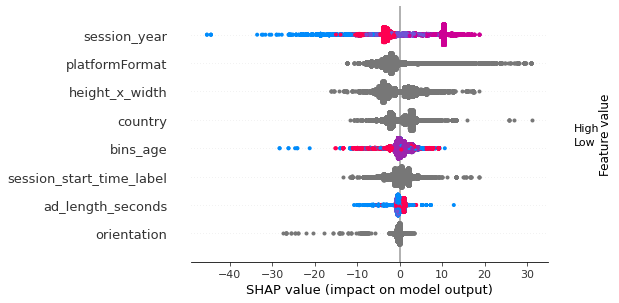

In [33]:
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])

#shap.summary_plot(shap_values, Xdata_val)
shap.summary_plot(shap_values, Xdata_val)


In [34]:
model.get_feature_importance(prettified=True)


Feature Id  Importances
0              session_year    37.953386
1            platformFormat    22.808351
2            height_x_width    15.944159
3  session_start_time_label    10.460647
4                  bins_age     7.049004
5                   country     3.605611
6               orientation     1.306198
7         ad_length_seconds     0.872645

In [35]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xdata_train)


In [36]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[1:1000], Xdata_val.iloc[1:1000])


In [37]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[600,:], Xdata_val.iloc[600,:])


In [38]:
#feature_names = Xdata_train.columns.tolist()
#feature_names

In [39]:
#shap_df = pd.DataFrame(shap_values, columns=feature_names)

In [40]:
#shap_df

In [41]:
#shap_df = shap_df.add_suffix('_shap')


In [42]:
#merged= pd.concat([shap_df, Xdata_train], axis=1)
#merged.head()

In [43]:
#merged["sign"] = np.sign(merged.country_shap)
#merged.head()
#merged.to_csv('shap.csv')

In [44]:
# # Group By dataframe on categorical values
# d = merged.groupby(['country'], sort=False)
  
# # creating lambda function to calculate
# # positive as well as negative values
# def pos(col): 
#   return col[col > 0].sum()
  
# def neg(col): 
# #   return col[col < 0].sum()
  
  
# # Apply lambda function to particular
# # column
# x = (d['height_x_width_shap'].agg([('negative_values', neg),
#                       ('positive_values', pos)
#                       ]))

# x.sort_values(by=['negative_values','positive_values']).head(25)


## Active Attentive Seconds


In [123]:
X = df.drop(['active_attentive_seconds', 'passive_attentive_seconds', \
        'max_continuous_attentive_seconds', 'attention_score_avg' , 'is_using_headphones', 'ad_type', 'user_id'], axis=1)
Y = df['active_attentive_seconds']
#,'is_using_headphones', 'ad_type', 'ad_length_seconds','orientation', 'country', 'gender' 

In [124]:
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.3, random_state=0)

categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

[0 1 2 3 5 7 8]


In [125]:
from catboost import CatBoostRegressor


In [126]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100


In [127]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.5, 0.7, 0.8)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 2000
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'
    param['bootstrap_type']='Bayesian'
    param['bagging_temperature']= 0.5
    param['sampling_frequency'] = 'PerTreeLevel'
    param['leaf_estimation_method']= 'Gradient'
    regressor = CatBoostRegressor(**param)

    regressor.fit(Xdata_train.copy(), Ydata_train.copy(),cat_features=categorical_features_indices,
                  eval_set=[(Xdata_val.copy(), Ydata_val.copy())],
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(Ydata_val, regressor.predict(Xdata_val.copy()))
    return loss

In [128]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=2000, n_jobs=-1, timeout=240)

[I 2022-10-13 20:32:46,187] A new study created in memory with name: catboost-seed1
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The distribution is specified by [0.5, 0.7] and step=0.8, but the range is not divisible by `step`. It will be replaced by [0.5, 0.5].
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2022-10-13 20:33:14,095] Trial 0 finished with value: 0.6445289013795216 and parameters: {'learning_rate': 0.5, 'depth': 13, 'l2_leaf_reg': 3.5, 'min_child_samples': 32}. Best is trial 0 with value: 0.6445289013795216.
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases

CPU times: user 1h 7min 37s, sys: 2min 54s, total: 1h 10min 31s
Wall time: 4min 26s


In [129]:
study.best_value


0.6353920060406258

In [130]:
study.best_params


{'learning_rate': 0.5, 'depth': 13, 'l2_leaf_reg': 4.5, 'min_child_samples': 1}

In [131]:
%%time
model = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
                                        depth=study.best_params['depth'],
                                        l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        min_child_samples=study.best_params['min_child_samples'],
                                        grow_policy='Depthwise',
                                        iterations=2000,
                                        use_best_model=True,
                                        loss_function='RMSE',
                                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=RANDOM_SEED,
                                        logging_level='Silent',
                                        bootstrap_type='Bayesian',
                                        bagging_temperature= 0.5,
                                        sampling_frequency = 'PerTreeLevel',
                                        leaf_estimation_method = 'Gradient')

model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), 
          use_best_model = True,plot=True,verbose_eval=1000, early_stopping_rounds=EARLY_STOPPING_ROUND)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 2000, 'learning_rate': 0.5, 'depth': 13, 'l2_leaf_reg': 4.5, 'loss_function': 'RMSE', 'od_wait': 20, 'od_type': 'iter', 'leaf_estimation_method': 'Gradient', 'use_best_model': True, 'logging_level': 'Silent', 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'bagging_temperature': 0.5, 'bootstrap_type': 'Bayesian', 'sampling_frequency': 'PerTreeLevel', 'random_state': 1, 'grow_policy': 'Depthwise', 'min_child_samples': 1}
Best Score:
{'learn': {'MAPE': 0.4251550854230956, 'MAE': 0.49390054441161346, 'R2': 0.5788817312108241, 'RMSE': 0.6961377952037237, 'NumErrors:greater_than=0.5': 0.3686312310658221}, 'validation': {'MAPE': 0.4990995352083861, 'MAE': 0.579977375984247, 'R2': 0.42563827095117757, 'RMSE': 0.7971148013331331, 'NumErrors:greater_than=0.5': 0.43336010709504685}}
Best Iteration:
78
CPU times: user 1min 53s, sys: 10.6 s, total: 2min 4s
Wall time: 8.36 s


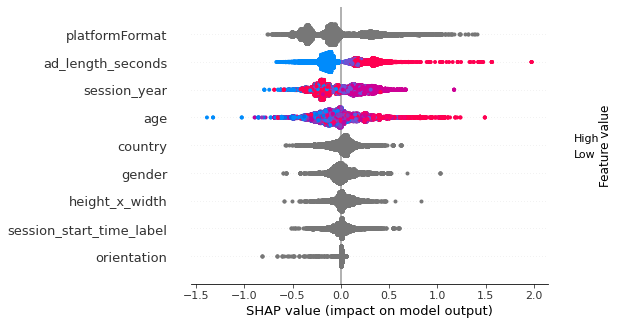

In [132]:
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])

#shap.summary_plot(shap_values, Xdata_val)
shap.summary_plot(shap_values, Xdata_val)


In [133]:
model.get_feature_importance(prettified=True)


Feature Id  Importances
0                       age    26.422685
1            platformFormat    19.874065
2         ad_length_seconds    17.820495
3              session_year    15.494921
4  session_start_time_label     5.947965
5                    gender     5.737752
6            height_x_width     4.509743
7                   country     3.875017
8               orientation     0.317357

In [36]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xdata_train)


In [37]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[1:1000], Xdata_val.iloc[1:1000])


In [38]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[600,:], Xdata_val.iloc[600,:])


## Passive Attentive Seconds


In [110]:
X = df.drop(['active_attentive_seconds', 'passive_attentive_seconds', \
        'max_continuous_attentive_seconds', 'attention_score_avg' , 'is_using_headphones', 'ad_type', 'user_id'], axis=1)
Y = df['passive_attentive_seconds']
#,'is_using_headphones', 'ad_type', 'ad_length_seconds','orientation', 'country', 'gender' 

In [111]:
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.3, random_state=0)

categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

[0 1 2 3 5 7 8]


In [112]:
from catboost import CatBoostRegressor


In [113]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100


In [114]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.5, 0.7, 0.8)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 2000
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'
    param['bootstrap_type']='Bayesian'
    param['bagging_temperature']= 0.5
    param['sampling_frequency'] = 'PerTreeLevel'
    param['leaf_estimation_method']= 'Gradient'
    regressor = CatBoostRegressor(**param)

    regressor.fit(Xdata_train.copy(), Ydata_train.copy(),cat_features=categorical_features_indices,
                  eval_set=[(Xdata_val.copy(), Ydata_val.copy())],
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(Ydata_val, regressor.predict(Xdata_val.copy()))
    return loss

In [115]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=2000, n_jobs=-1, timeout=240)

[I 2022-10-13 20:23:40,106] A new study created in memory with name: catboost-seed1
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The distribution is specified by [0.5, 0.7] and step=0.8, but the range is not divisible by `step`. It will be replaced by [0.5, 0.5].
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2022-10-13 20:24:15,692] Trial 15 finished with value: 0.7014819447012337 and parameters: {'learning_rate': 0.5, 'depth': 11, 'l2_leaf_reg': 3.0, 'min_child_samples': 4}. Best is trial 15 with value: 0.7014819447012337.
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/release

CPU times: user 1h 4min 55s, sys: 2min 45s, total: 1h 7min 41s
Wall time: 4min 16s


In [116]:
study.best_value


0.6921382867148633

In [117]:
study.best_params


{'learning_rate': 0.5,
 'depth': 15,
 'l2_leaf_reg': 5.5,
 'min_child_samples': 32}

In [120]:
%%time
model = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
                                        depth=study.best_params['depth'],
                                        l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        min_child_samples=study.best_params['min_child_samples'],
                                        grow_policy='Depthwise',
                                        iterations=2000,
                                        use_best_model=True,
                                        loss_function='RMSE',
                                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=RANDOM_SEED,
                                        logging_level='Silent',
                                        bootstrap_type='Bayesian',
                                        bagging_temperature= 0.5,
                                        sampling_frequency = 'PerTreeLevel',
                                        leaf_estimation_method = 'Gradient')

model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), 
          use_best_model = True,plot=True,verbose_eval=1000, early_stopping_rounds=EARLY_STOPPING_ROUND)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 2000, 'learning_rate': 0.5, 'depth': 15, 'l2_leaf_reg': 5.5, 'loss_function': 'RMSE', 'od_wait': 20, 'od_type': 'iter', 'leaf_estimation_method': 'Gradient', 'use_best_model': True, 'logging_level': 'Silent', 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'bagging_temperature': 0.5, 'bootstrap_type': 'Bayesian', 'sampling_frequency': 'PerTreeLevel', 'random_state': 1, 'grow_policy': 'Depthwise', 'min_child_samples': 32}
Best Score:
{'learn': {'MAPE': 0.47011558645303597, 'MAE': 0.5432973002396803, 'R2': 0.5184810892376488, 'RMSE': 0.7291655237282297, 'NumErrors:greater_than=0.5': 0.4422335444781052}, 'validation': {'MAPE': 0.540421653445348, 'MAE': 0.6312715035772143, 'R2': 0.37835391733634205, 'RMSE': 0.8319484931545392, 'NumErrors:greater_than=0.5': 0.51095046854083}}
Best Iteration:
108
CPU times: user 1min 33s, sys: 8.35 s, total: 1min 41s
Wall time: 6.81 s


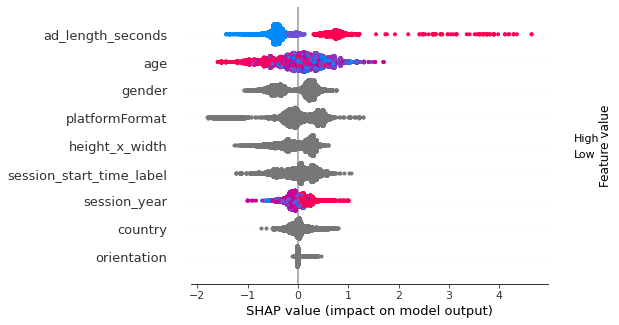

In [121]:
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])

#shap.summary_plot(shap_values, Xdata_val)
shap.summary_plot(shap_values, Xdata_val)


In [122]:
model.get_feature_importance(prettified=True)


Feature Id  Importances
0                       age    26.479438
1         ad_length_seconds    24.811487
2            platformFormat    16.850213
3              session_year     8.946707
4  session_start_time_label     7.273028
5            height_x_width     5.581927
6                   country     5.303661
7                    gender     4.608167
8               orientation     0.145373

In [70]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xdata_train)


In [71]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[1:1000], Xdata_val.iloc[1:1000])


In [72]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[600,:], Xdata_val.iloc[600,:])


## max_continuous_attentive_seconds


In [134]:
X = df.drop(['active_attentive_seconds', 'passive_attentive_seconds', \
        'max_continuous_attentive_seconds', 'attention_score_avg' , 'is_using_headphones', 'ad_type', 'user_id'], axis=1)
Y = df['max_continuous_attentive_seconds']
#,'is_using_headphones', 'ad_type', 'ad_length_seconds','orientation', 'country', 'gender' 

In [135]:
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.3, random_state=0)

categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

[0 1 2 3 5 7 8]


In [136]:
from catboost import CatBoostRegressor


In [137]:
SAMPLE_RATE = 0.4
RANDOM_SEED = 1
EARLY_STOPPING_ROUND = 100


In [138]:
def objective(trial):
    param = {}
    param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.5, 0.7, 0.8)
    param['depth'] = trial.suggest_int('depth', 9, 15)
    param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    param['grow_policy'] = 'Depthwise'
    param['iterations'] = 2000
    param['use_best_model'] = True
    param['eval_metric'] = 'RMSE'
    param['od_type'] = 'iter'
    param['od_wait'] = 20
    param['random_state'] = RANDOM_SEED
    param['logging_level'] = 'Silent'
    param['bootstrap_type']='Bayesian'
    param['bagging_temperature']= 0.5
    param['sampling_frequency'] = 'PerTreeLevel'
    param['leaf_estimation_method']= 'Gradient'
    regressor = CatBoostRegressor(**param)

    regressor.fit(Xdata_train.copy(), Ydata_train.copy(),cat_features=categorical_features_indices,
                  eval_set=[(Xdata_val.copy(), Ydata_val.copy())],
                  early_stopping_rounds=EARLY_STOPPING_ROUND)
    loss = mean_squared_error(Ydata_val, regressor.predict(Xdata_val.copy()))
    return loss

In [139]:
%%time
study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
study.optimize(objective, n_trials=2000, n_jobs=-1, timeout=240)

[I 2022-10-13 20:44:58,047] A new study created in memory with name: catboost-seed1
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
The distribution is specified by [0.5, 0.7] and step=0.8, but the range is not divisible by `step`. It will be replaced by [0.5, 0.5].
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
[I 2022-10-13 20:45:18,522] Trial 6 finished with value: 0.4643766115271206 and parameters: {'learning_rate': 0.5, 'depth': 9, 'l2_leaf_reg': 2.5, 'min_child_samples': 16}. Best is trial 6 with value: 0.4643766115271206.
suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/

CPU times: user 1h 5min 4s, sys: 2min 36s, total: 1h 7min 40s
Wall time: 4min 16s


In [140]:
study.best_value


0.4478797638174983

In [141]:
study.best_params


{'learning_rate': 0.5, 'depth': 12, 'l2_leaf_reg': 4.5, 'min_child_samples': 1}

In [142]:
%%time
model = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
                                        depth=study.best_params['depth'],
                                        l2_leaf_reg=study.best_params['l2_leaf_reg'],
                                        min_child_samples=study.best_params['min_child_samples'],
                                        grow_policy='Depthwise',
                                        iterations=2000,
                                        use_best_model=True,
                                        loss_function='RMSE',
                                        custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
                                        od_type='iter',
                                        od_wait=20,
                                        random_state=RANDOM_SEED,
                                        logging_level='Silent',
                                        bootstrap_type='Bayesian',
                                        bagging_temperature= 0.5,
                                        sampling_frequency = 'PerTreeLevel',
                                        leaf_estimation_method = 'Gradient')

model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), 
          use_best_model = True,plot=True,verbose_eval=1000, early_stopping_rounds=EARLY_STOPPING_ROUND)
print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())
print('Best Score:')
print(model.get_best_score())
print('Best Iteration:')
print(model.get_best_iteration())


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 2000, 'learning_rate': 0.5, 'depth': 12, 'l2_leaf_reg': 4.5, 'loss_function': 'RMSE', 'od_wait': 20, 'od_type': 'iter', 'leaf_estimation_method': 'Gradient', 'use_best_model': True, 'logging_level': 'Silent', 'custom_metric': ['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'], 'bagging_temperature': 0.5, 'bootstrap_type': 'Bayesian', 'sampling_frequency': 'PerTreeLevel', 'random_state': 1, 'grow_policy': 'Depthwise', 'min_child_samples': 1}
Best Score:
{'learn': {'MAPE': 0.3067577127857901, 'MAE': 0.36556812280184525, 'R2': 0.6683244295547695, 'RMSE': 0.5655767466775429, 'NumErrors:greater_than=0.5': 0.22991829615349307}, 'validation': {'MAPE': 0.3677835124344809, 'MAE': 0.44022465727900173, 'R2': 0.5229674806329607, 'RMSE': 0.6692381965988239, 'NumErrors:greater_than=0.5': 0.28572958500669343}}
Best Iteration:
97
CPU times: user 1min 26s, sys: 8.49 s, total: 1min 35s
Wall time: 6.39 s


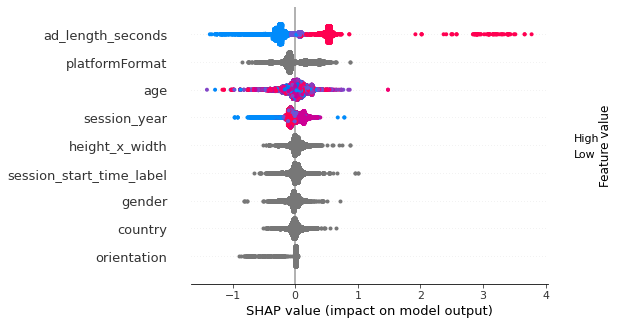

In [143]:
import shap
shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices), 
                                                                     type="ShapValues")
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])

#shap.summary_plot(shap_values, Xdata_val)
shap.summary_plot(shap_values, Xdata_val)


In [144]:
model.get_feature_importance(prettified=True)


Feature Id  Importances
0         ad_length_seconds    48.082400
1            platformFormat    16.931639
2                       age    13.744609
3  session_start_time_label     5.353707
4            height_x_width     4.006386
5              session_year     3.603710
6                   country     2.882249
7               orientation     2.758310
8                    gender     2.636990

In [84]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xdata_train)


In [85]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[1:1000], Xdata_val.iloc[1:1000])


In [86]:
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[600,:], Xdata_val.iloc[600,:])


## platformat


In [145]:
def label_ticket(row):
    if isinstance(row['platformFormat'], str) and '15' in row['platformFormat']:
        return 0
    if isinstance(row['platformFormat'], str) and '20' in row['platformFormat']:
        return 1
    if isinstance(row['platformFormat'], str) and '30' in row['platformFormat']:
        return 2
    if isinstance(row['platformFormat'], str) and 'stream' in row['platformFormat']:
        return 3
    return 4

In [146]:
df.platformFormat.value_counts()

linear_tv_lte_15_seconds               16350
ctv_lte_15_seconds                     15922
ctv_30_seconds                         10648
linear_tv_30_seconds                    8262
ctv_20_seconds                          4410
bvod_mobile_lte_15_seconds              1919
yahoo_native-pre-roll_inthewild         1276
yahoo_native-moment_video_inthewild      947
bvod_mobile_20_seconds                   911
bvod_mobile_30_seconds                   626
yahoo_native-stream_video_intercept      376
yahoo_native-stream_video_inthewild      345
linear_tv_60_seconds                     255
Name: platformFormat, dtype: int64

In [147]:
df['Platform_format_encoded'] = df.apply(label_ticket, axis=1)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
df.max_continuous_attentive_seconds.value_counts()

15.0     19404
30.0     11673
0.0       5754
20.0      4058
16.0      4028
         ...  
164.0        1
56.0         1
98.0         1
64.0         1
132.0        1
Name: max_continuous_attentive_seconds, Length: 77, dtype: int64

In [149]:
#weights = [df.Platform_format_encoded.value_counts().sum() / df.Platform_format_encoded.value_counts()[i] for i in 
               #set(Platform_format_encoded.values())]

In [173]:
#X = df.drop(['active_attentive_seconds', 'passive_attentive_seconds', \
        'max_continuous_attentive_seconds', 'attention_score_avg' , 'is_using_headphones', 'ad_type', 'user_id', 'Platform_format_encoded', 'platformFormat'], axis=1)
#Y = df['Platform_format_encoded']
#,'is_using_headphones', 'ad_type', 'ad_length_seconds','orientation', 'country', 'gender' 

IndentationError: unexpected indent (32757917.py, line 2)

In [39]:
df = df[(df.country == "AU")]


In [40]:
bins = [0,2,350]
labels=[0,1]
df['bins_MAX'] = pd.cut(df['max_continuous_attentive_seconds'], bins=bins, labels=labels, include_lowest=True)


In [41]:
df['bins_MAX'].value_counts()

1    31313
0     5231
Name: bins_MAX, dtype: int64

In [42]:
X = df.drop(['active_attentive_seconds', 'passive_attentive_seconds', 'bins_MAX',\
        'max_continuous_attentive_seconds', 'attention_score_avg' , 'is_using_headphones', 'ad_type', 'user_id', 'age' ], axis=1)
Y = df['bins_MAX']

In [43]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36544 entries, 995 to 202927
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   session_start_time_label  36544 non-null  object  
 1   orientation               36544 non-null  object  
 2   platformFormat            36544 non-null  object  
 3   country                   36544 non-null  object  
 4   ad_length_seconds         36544 non-null  float64 
 5   session_year              36544 non-null  int64   
 6   height_x_width            36544 non-null  object  
 7   bins_age                  36544 non-null  category
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 2.3+ MB


In [44]:
Y.describe()

count     36544
unique        2
top           1
freq      31313
Name: bins_MAX, dtype: int64

In [45]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]


In [46]:

# from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
# from imblearn.under_sampling import NearMiss, RandomUnderSampler
# from imblearn.over_sampling import SMOTENC


# #Instantiate SMOTENC algorith with 60% oversampling
# sm = SMOTENC(categorical_features=categorical_features_indices, random_state=123, sampling_strategy=.6)
# X_ROS, Y_ROS = sm.fit_resample(X, Y)
# #smt = SMOTE(random_state=777)
# #rus = RandomUnderSampler(random_state=777)
# #ros = RandomOverSampler(random_state=777)
# #X_ROS, Y_ROS = ros.fit_resample(X, Y)



In [47]:
#profile = ProfileReport(df, title="Amplified Profiling Report")
#profile.to_notebook_iframe()

In [48]:
# X_ROS.info()

In [49]:
# Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.3, random_state=0)

# categorical_features_indices = np.where(X.dtypes != np.float)[0]
# print(categorical_features_indices)

In [50]:
Xdata_train, Xdata_val, Ydata_train, Ydata_val = train_test_split(X, Y, test_size=0.3, random_state=0)

categorical_features_indices = np.where(X.dtypes != np.float)[0]
print(categorical_features_indices)

[0 1 2 3 5 6 7]


In [51]:
# def objective(trial):
#     param = {}
#     param['learning_rate'] = trial.suggest_discrete_uniform("learning_rate", 0.5, 0.7, 0.8)
#     param['depth'] = trial.suggest_int('depth', 9, 15)
#     param['l2_leaf_reg'] = trial.suggest_discrete_uniform('l2_leaf_reg', 1.0, 5.5, 0.5)
#     param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
#     param['grow_policy'] = 'Depthwise'
#     param['iterations'] = 2000
#     param['use_best_model'] = True
#     param['eval_metric'] = 'AUC'
#     param['od_type'] = 'iter'
#     param['od_wait'] = 20
#     param['random_state'] = RANDOM_SEED
#     param['logging_level'] = 'Silent'
#     param['bootstrap_type']='Bayesian'
#     param['bagging_temperature']= 0.5
#     param['sampling_frequency'] = 'PerTreeLevel'
#     param['leaf_estimation_method']= 'Gradient'
#     param['feature_border_type']= 'MaxLogSum'
#     param['max_ctr_complexity'] = 2
#     param['fold_len_multiplier']=2
#     regressor = CatBoostClassifier(**param)

#     regressor.fit(Xdata_train.copy(), Ydata_train.copy(),cat_features=categorical_features_indices,
#                   eval_set=[(Xdata_val.copy(), Ydata_val.copy())],
#                   early_stopping_rounds=EARLY_STOPPING_ROUND)
#     loss = mean_squared_error(Ydata_val, regressor.predict(Xdata_val.copy()))
#     return loss

In [52]:
# %%time
# study = optuna.create_study(study_name=f'catboost-seed{RANDOM_SEED}')
# study.optimize(objective, n_trials=2000, n_jobs=-1, timeout=240)

In [53]:
# best_params = {
#             'bagging_temperature': 0.5,
#             'depth': 8,
#             'iterations': 200,
#             'l2_leaf_reg': 30,
#             'learning_rate': 0.05,
#             'sampling_frequency': 'PerTreeLevel',
#             'leaf_estimation_method': 'Gradient',
#             'random_strength': 0.8,
#             'boosting_type': 'Ordered',
#             'feature_border_type': 'MaxLogSum',
#             'l2_leaf_reg': 50,
#             'max_ctr_complexity': 2,
#             'fold_len_multiplier': 2}

In [54]:
# %%time
# model = CatBoostRegressor(learning_rate=study.best_params['learning_rate'],
#                                         depth=study.best_params['depth'],
#                                         l2_leaf_reg=study.best_params['l2_leaf_reg'],
#                                         min_child_samples=study.best_params['min_child_samples'],
#                                         grow_policy='Depthwise',
#                                         iterations=2000,
#                                         use_best_model=True,
#                                         loss_function='RMSE',
#                                         custom_metric=['R2', 'NumErrors:greater_than=0.5', 'MAE', 'MAPE'],
#                                         od_type='iter',
#                                         od_wait=20,
#                                         random_state=RANDOM_SEED,
#                                         logging_level='Silent',
#                                         bootstrap_type='Bayesian',
#                                         bagging_temperature= 0.5,
#                                         sampling_frequency = 'PerTreeLevel',
#                                         leaf_estimation_method = 'Gradient')

# model.fit(Xdata_train, Ydata_train, cat_features=categorical_features_indices, eval_set=(Xdata_val, Ydata_val), 
#           use_best_model = True,plot=True,verbose_eval=1000, early_stopping_rounds=EARLY_STOPPING_ROUND)
# print('CatBoost model is fitted: ' + str(model.is_fitted()))
# print('CatBoost model parameters:')
# print(model.get_params())
# print('Best Score:')
# print(model.get_best_score())
# print('Best Iteration:')
# print(model.get_best_iteration())


In [55]:
Ydata_val.shape

(10964,)

In [67]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36544 entries, 995 to 202927
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   session_start_time_label  36544 non-null  object  
 1   orientation               36544 non-null  object  
 2   platformFormat            36544 non-null  object  
 3   country                   36544 non-null  object  
 4   ad_length_seconds         36544 non-null  float64 
 5   session_year              36544 non-null  int64   
 6   height_x_width            36544 non-null  object  
 7   bins_age                  36544 non-null  category
dtypes: category(1), float64(1), int64(1), object(5)
memory usage: 2.3+ MB


In [56]:
### Parameter Tuning ######
best_params = {
            'bagging_temperature': 0.5,
            'depth': 8,
            'iterations': 200,
            'l2_leaf_reg': 30,
            'learning_rate': 0.05,
            'sampling_frequency': 'PerTreeLevel',
            'leaf_estimation_method': 'Gradient',
            'random_strength': 0.8,
            'boosting_type': 'Ordered',
            'feature_border_type': 'MaxLogSum',
            'l2_leaf_reg': 50,
            'max_ctr_complexity': 2,
            'fold_len_multiplier': 2}

model = CatBoostClassifier(**best_params,
                               loss_function='Logloss',
                               eval_metric='AUC',
                               nan_mode='Min',
                               thread_count=8,
                               task_type='CPU',
                               custom_metric=['Accuracy', 'F1', 'Precision', 'Recall'],
                               #per_float_feature_quantization='2:border_count=1024',
                               bootstrap_type='Bayesian',
                               class_weights = [0.7, 0.3],
                               verbose=True)


model.fit(Xdata_train, Ydata_train,
                              eval_set=(Xdata_val, Ydata_val),
                              cat_features=categorical_features_indices,
                              verbose_eval=50,
                              early_stopping_rounds=30,
                              use_best_model=True,
                              plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5104736	best: 0.5104736 (0)	total: 21.6ms	remaining: 4.3s
50:	test: 0.6743615	best: 0.6744494 (49)	total: 1.42s	remaining: 4.15s
100:	test: 0.6771198	best: 0.6771198 (100)	total: 2.79s	remaining: 2.74s
150:	test: 0.6783084	best: 0.6783084 (150)	total: 3.93s	remaining: 1.27s
199:	test: 0.6781825	best: 0.6788638 (197)	total: 4.94s	remaining: 0us

bestTest = 0.6788637697
bestIteration = 197

Shrink model to first 198 iterations.


In [57]:

print('CatBoost model is fitted: ' + str(model.is_fitted()))
print('CatBoost model parameters:')
print(model.get_params())

print('Best Score:')
print(model.get_best_score())

print('Best Iteration:')
print(model.get_best_iteration())


CatBoost model is fitted: True
CatBoost model parameters:
{'iterations': 200, 'learning_rate': 0.05, 'depth': 8, 'l2_leaf_reg': 50, 'loss_function': 'Logloss', 'feature_border_type': 'MaxLogSum', 'nan_mode': 'Min', 'leaf_estimation_method': 'Gradient', 'thread_count': 8, 'verbose': True, 'max_ctr_complexity': 2, 'class_weights': [0.7, 0.3], 'random_strength': 0.8, 'custom_metric': ['Accuracy', 'F1', 'Precision', 'Recall'], 'eval_metric': 'AUC', 'bagging_temperature': 0.5, 'fold_len_multiplier': 2, 'boosting_type': 'Ordered', 'task_type': 'CPU', 'bootstrap_type': 'Bayesian', 'sampling_frequency': 'PerTreeLevel'}
Best Score:
{'learn': {'Accuracy:use_weights=false': 0.8586786551993745, 'Recall:use_weights=false': 1.0, 'Precision:use_weights=false': 0.8730983456646437, 'Accuracy:use_weights=true': 0.7357358763154074, 'Logloss': 0.5473788569079509, 'Precision:use_weights=true': 0.7467471014850638, 'Recall:use_weights=true': 1.0, 'F1:use_weights=true': 0.841436233571753, 'F1:use_weights=fals

In [58]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score



In [59]:
preds_class = model.predict(Xdata_val)
    
        
display(F'Learning Rate set to: {model.get_all_params()["learning_rate"]}')
display(F'Accuracy Score: {accuracy_score(Ydata_val, preds_class)}')
display(F"F1-Score: {f1_score(Ydata_val, preds_class,average='weighted')}")

matrix = confusion_matrix(Ydata_val, preds_class)
print('-'*50)
print('Confusion Matrix: ')
print(matrix)
print('-'*50)

'Learning Rate set to: 0.05000000074505806'

'Accuracy Score: 0.8416636264137176'

'F1-Score: 0.8130021102127452'

--------------------------------------------------
Confusion Matrix: 
[[ 253 1326]
 [ 410 8975]]
--------------------------------------------------


In [60]:
# !pip install plot-metric
# !pip install metriculous
# !pip install scikit-plot

In [61]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [62]:
from plot_metric.functions import BinaryClassification


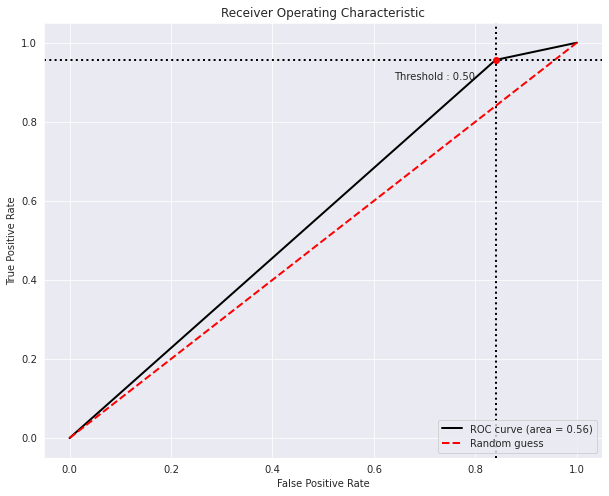

In [63]:
# Visualisation with plot_metric
bc = BinaryClassification(Ydata_val, preds_class, labels=["Class 0", "Class 1"], threshold=0.5)

# Figures
plt.figure(figsize=(10,8))
bc.plot_roc_curve()
plt.show()


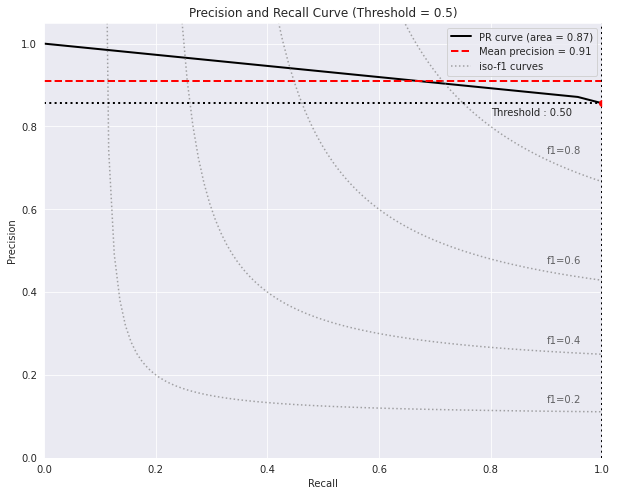

In [64]:
plt.figure(figsize=(10,8))

bc.plot_precision_recall_curve()
plt.show()


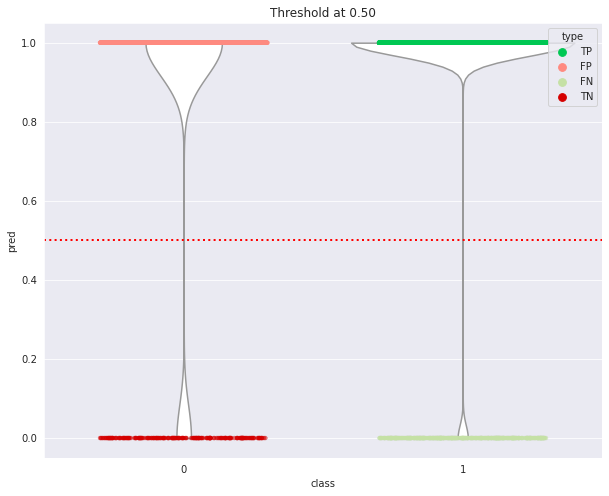

In [65]:

plt.figure(figsize=(10,8))

bc.plot_class_distribution()
plt.show()


In [66]:
import bctools as bc


conf_matrix, metrics_fixed_thresh_df = bc.utilities.get_confusion_matrix_and_metrics_df(
    true_y = Ydata_val, 
    predicted_proba = preds_class,
    threshold = 0.5 # default = 0.5
)

display(conf_matrix, metrics_fixed_thresh_df)

array([[ 253, 1326],
       [ 410, 8975]])

threshold_dependent_metric   value
0                   accuracy  0.8417
1          balanced_accuracy  0.5583
2                   f1_score  0.9118
3                  precision  0.8713
4                     recall  0.9563
5               cohens_kappa  0.1536
6         matthews_corr_coef  0.1717

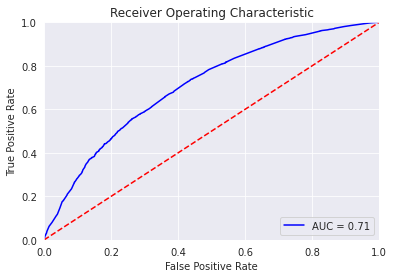

In [174]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(Xdata_val)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(Ydata_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [51]:
import bctools as bc


In [52]:
bc.curve_ROC_plot(true_y = Ydata_val, 
                                   predicted_proba = preds_class)

In [68]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=0)

train = X_train
train['id_target'] = Y_train
mydf = X_val
mydf['id_target'] = Y_val

col_list = ['session_start_time_label', 'orientation','platformFormat','country','ad_length_seconds','session_year','height_x_width','bins_age']


In [69]:
def bid_col (mydf, col, target, num):
    df1 = mydf.loc[mydf[target] == 1, [col, target]]
    df2 = df1.groupby(col).agg(np.count_nonzero).sort_values(by = target, ascending=False)
    df3 = df2.iloc[0:num,]
    df3 = df3.reset_index()
    df3['key'] = 0
    return df3
def df_list_make(train, col_list, targeted_id):
    df_list = []
    for i in col_list:
        j = bid_col (train, col = i, target = targeted_id, num = 100000)
        df_list.append(j)
    return df_list
df_list = df_list_make(train, col_list, targeted_id = 'id_target')

def cross_join (df_list, col_list):
    lenth = len(df_list)-1
    i = 0
    mydf = df_list[i]
    while i < lenth:
        mydf = pd.merge(mydf, df_list[i+1], on= 'key')
        i = i+1
    mydf = mydf[col_list]
    return mydf

In [70]:
df_list = df_list_make(train, col_list, targeted_id = 'id_target')
df_list

[  session_start_time_label  id_target  key
 0                afternoon       9375    0
 1                  evening       8404    0
 2              pre-morning       3682    0
 3                  morning       3603    0,
   orientation  id_target  key
 0   landscape      24131    0
 1    portrait        933    0,
                          platformFormat  id_target  key
 0              linear_tv_lte_15_seconds      10856    0
 1                  linear_tv_30_seconds       5700    0
 2                    ctv_lte_15_seconds       3972    0
 3                        ctv_30_seconds       1906    0
 4                        ctv_20_seconds        637    0
 5            bvod_mobile_lte_15_seconds        564    0
 6   yahoo_native-moment_video_inthewild        428    0
 7       yahoo_native-pre-roll_inthewild        371    0
 8                bvod_mobile_30_seconds        353    0
 9                  linear_tv_60_seconds        186    0
 10  yahoo_native-stream_video_inthewild         91    0,


In [71]:
df_cross = cross_join (df_list, col_list)
df_cross


Passing 'suffixes' which cause duplicate columns {'id_target_x'} in the result is deprecated and will raise a MergeError in a future version.


session_start_time_label orientation  \
0                     afternoon   landscape   
1                     afternoon   landscape   
2                     afternoon   landscape   
3                     afternoon   landscape   
4                     afternoon   landscape   
...                         ...         ...   
985595                  morning    portrait   
985596                  morning    portrait   
985597                  morning    portrait   
985598                  morning    portrait   
985599                  morning    portrait   

                             platformFormat country  ad_length_seconds  \
0                  linear_tv_lte_15_seconds      AU               15.0   
1                  linear_tv_lte_15_seconds      AU               15.0   
2                  linear_tv_lte_15_seconds      AU               15.0   
3                  linear_tv_lte_15_seconds      AU               15.0   
4                  linear_tv_lte_15_seconds      AU               15.0   
...                                     ...     ...                ...   
985595  yahoo_native-stream_video_inthewild      AU               14.0   
985596  yahoo_native-stream_video_inthewild      AU               14.0   
985597  yahoo_native-stream_video_inthewild      AU               14.0   
985598  yahoo_native-stream_video_inthewild      AU               14.0   
985599  yahoo_native-stream_video_inthewild      AU               14.0   

        session_year height_x_width bins_age  
0               2022      1080X1920        2  
1               2022      1080X1920        3  
2               2022      1080X1920        1  
3               2022      1080X1920        0  
4               2022        320X568        2  
...              ...            ...      ...  
985595          2018        336X428        0  
985596          2018        330X428        2  
985597          2018        330X428        3  
985598          2018        330X428        1  
985599          2018        330X428        0  

[985600 rows x 8 columns]

In [73]:
#Call the bidlist functions
df_list = df_list_make(train, col_list, targeted_id = 'id_target')
df_cross = cross_join (df_list, col_list)

categorical_features = col_list

categorical_features_indices = [df_cross.columns.get_loc(col) for col in categorical_features]


#Use your trained catboost model. If it isn't called clf, change the name here. 
probs = model.predict_proba(df_cross)
df_prob = pd.DataFrame({'Negative': probs[:, 0], 'Positive': probs[:, 1]})
bid_model = df_cross
bid_model['probs'] = df_prob['Positive']

#This outputs every permutation of the columns selected for the bidlist and assigned them a probability
bid_model

Passing 'suffixes' which cause duplicate columns {'id_target_x'} in the result is deprecated and will raise a MergeError in a future version.


session_start_time_label orientation  \
0                     afternoon   landscape   
1                     afternoon   landscape   
2                     afternoon   landscape   
3                     afternoon   landscape   
4                     afternoon   landscape   
...                         ...         ...   
985595                  morning    portrait   
985596                  morning    portrait   
985597                  morning    portrait   
985598                  morning    portrait   
985599                  morning    portrait   

                             platformFormat country  ad_length_seconds  \
0                  linear_tv_lte_15_seconds      AU               15.0   
1                  linear_tv_lte_15_seconds      AU               15.0   
2                  linear_tv_lte_15_seconds      AU               15.0   
3                  linear_tv_lte_15_seconds      AU               15.0   
4                  linear_tv_lte_15_seconds      AU               15.0   
...                                     ...     ...                ...   
985595  yahoo_native-stream_video_inthewild      AU               14.0   
985596  yahoo_native-stream_video_inthewild      AU               14.0   
985597  yahoo_native-stream_video_inthewild      AU               14.0   
985598  yahoo_native-stream_video_inthewild      AU               14.0   
985599  yahoo_native-stream_video_inthewild      AU               14.0   

        session_year height_x_width bins_age     probs  
0               2022      1080X1920        2  0.643778  
1               2022      1080X1920        3  0.727040  
2               2022      1080X1920        1  0.771362  
3               2022      1080X1920        0  0.732662  
4               2022        320X568        2  0.649369  
...              ...            ...      ...       ...  
985595          2018        336X428        0  0.479670  
985596          2018        330X428        2  0.461226  
985597          2018        330X428        3  0.551462  
985598          2018        330X428        1  0.538974  
985599          2018        330X428        0  0.479670  

[985600 rows x 9 columns]

In [74]:
bid_model.to_csv('ag_amplified.csv', index=False)

In [82]:
df2 =bid_model.groupby(['session_start_time_label', 'height_x_width'])['probs'].mean().reset_index()
df2

session_start_time_label height_x_width     probs
0                  afternoon      1080X1920  0.620747
1                  afternoon        157X280  0.593321
2                  afternoon        179X320  0.575897
3                  afternoon        188X335  0.617181
4                  afternoon        196X350  0.600112
..                       ...            ...       ...
195              pre-morning         92X164  0.532357
196              pre-morning         95X335  0.582731
197              pre-morning         95X350  0.559458
198              pre-morning         95X374  0.593752
199              pre-morning         95X388  0.569169

[200 rows x 3 columns]

In [83]:
df2.to_csv('ag_amp_bidlist.csv',index=False)

In [87]:
df2['session_start_time_label'].value_counts()

afternoon      50
evening        50
morning        50
pre-morning    50
Name: session_start_time_label, dtype: int64

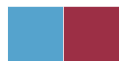

In [81]:
#sns.set_palette('icefire')
sns.set_palette(['#55a3cd', '#9c2f45'])
sns.palplot(sns.color_palette())

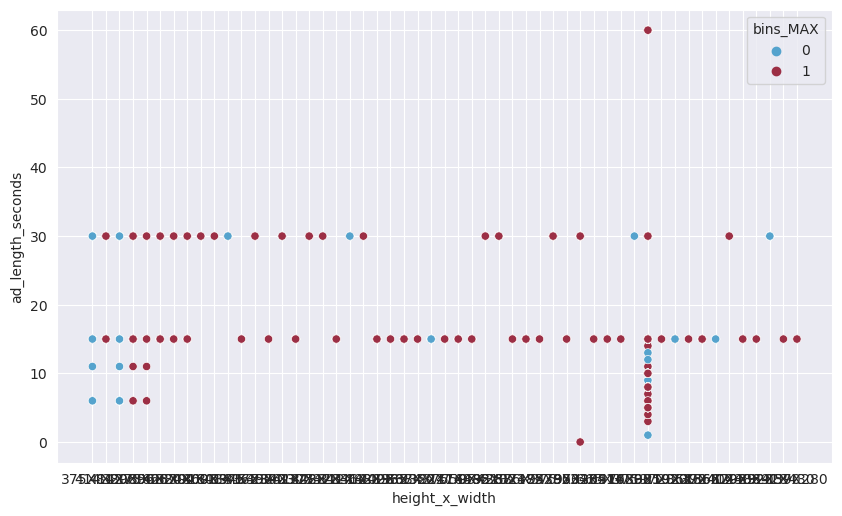

In [92]:
# Imblanced Data
plt.figure(figsize=(10,6),dpi=100)

sns.despine(left=False)
sns.scatterplot(x='height_x_width', y='ad_length_seconds', hue = 'bins_MAX', data=df)
plt.show()

In [99]:
!pip install explainerdashboard

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.2/279.2 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 137.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 21.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.0/471.0 kB 75.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.5/136.5 kB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.2/357.2 kB 67.0 MB/s eta 0:00:00
  Created wheel for dtreeviz: filename=dtreeviz-1.3.7-p

In [123]:
from explainerdashboard import ClassifierExplainer, ExplainerDashboard, InlineExplainer
explainer = ClassifierExplainer(model, Xdata_val, Ydata_val, cv = 2, model_output='logodds', 
                                cats=['session_start_time_label', 'orientation', 'platformFormat', 'height_x_width', 'bins_age'])



AssertionError: These new cats columns are already in X.columns: ['platformFormat', 'height_x_width', 'orientation', 'session_start_time_label', 'bins_age']! Please select a different name for your new cats columns!

In [121]:
InlineExplainer(explainer).shap.dependence(hide_cats=True, hide_index=True)



Calculating shap values...


In [114]:

Db.run(port=8051)

NameError: name 'Db' is not defined

In [ ]:
# def plot_roc_curve(Ydata_val, preds_class):
  
#   n_classes = len(np.unique(Ydata_val))
#   Ydata_val = label_binarize(Ydata_val, classes=np.arange(n_classes))
#   preds_class = label_binarize(preds_class, classes=np.arange(n_classes))

#   # Compute ROC curve and ROC area for each class
#   fpr = dict()
#   tpr = dict()
#   roc_auc = dict()
#   for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(Ydata_val[i], preds_class[i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
  
#   # Compute micro-average ROC curve and ROC area
#   fpr["micro"], tpr["micro"], _ = roc_curve(Ydata_val.ravel(), preds_class.ravel())
#   roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#   # First aggregate all false positive rates
#   all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#   # Then interpolate all ROC curves at this points
#   mean_tpr = np.zeros_like(all_fpr)
#   for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#   # Finally average it and compute AUC
#   mean_tpr /= n_classes

#   fpr["macro"] = all_fpr
#   tpr["macro"] = mean_tpr
#   roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#   # Plot all ROC curves
#   #plt.figure(figsize=(10,5))
#   plt.figure(dpi=1000)
#   lw = 2
#   plt.plot(fpr["micro"], tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.1f})".format(roc_auc["micro"]),
#     color="deeppink", linestyle=":", linewidth=4,)

#   plt.plot(fpr["macro"], tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.1f})".format(roc_auc["macro"]),
#     color="navy", linestyle=":", linewidth=4,)

#   colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
#   for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#         label="ROC curve of class {0} (area = {1:0.1f})".format(i, roc_auc[i]),)

#   plt.plot([0, 1], [0, 1], "k--", lw=lw)
#   plt.xlim([0.0, 1.0])
#   plt.ylim([0.0, 1.05])
#   plt.xlabel("False Positive Rate")
#   plt.ylabel("True Positive Rate")
#   plt.title("Receiver Operating Characteristic (ROC) curve")
#   plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=3)

In [152]:
# def plot_roc_curve(Ydata_val, preds_class):
  
#   n_classes = len(np.unique(Ydata_val))
#   Ydata_val = label_binarize(Ydata_val, classes=np.arange(n_classes))
#   preds_class = label_binarize(preds_class, classes=np.arange(n_classes))

#   # Compute ROC curve and ROC area for each class
#   fpr = dict()
#   tpr = dict()
#   roc_auc = dict()
#   for i in range(n_classes):
#     fpr[i], tpr[i], _ = roc_curve(Ydata_val[:, i], preds_class[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])
  
#   # Compute micro-average ROC curve and ROC area
#   fpr["micro"], tpr["micro"], _ = roc_curve(Ydata_val.ravel(), preds_class.ravel())
#   roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

#   # First aggregate all false positive rates
#   all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

#   # Then interpolate all ROC curves at this points
#   mean_tpr = np.zeros_like(all_fpr)
#   for i in range(n_classes):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

#   # Finally average it and compute AUC
#   mean_tpr /= n_classes

#   fpr["macro"] = all_fpr
#   tpr["macro"] = mean_tpr
#   roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#   # Plot all ROC curves
#   #plt.figure(figsize=(10,5))
#   plt.figure(dpi=1000)
#   lw = 2
#   plt.plot(fpr["micro"], tpr["micro"],
#     label="micro-average ROC curve (area = {0:0.1f})".format(roc_auc["micro"]),
#     color="deeppink", linestyle=":", linewidth=4,)

#   plt.plot(fpr["macro"], tpr["macro"],
#     label="macro-average ROC curve (area = {0:0.1f})".format(roc_auc["macro"]),
#     color="navy", linestyle=":", linewidth=4,)

#   colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
#   for i, color in zip(range(n_classes), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=lw,
#         label="ROC curve of class {0} (area = {1:0.1f})".format(i, roc_auc[i]),)

#   plt.plot([0, 1], [0, 1], "k--", lw=lw)
#   plt.xlim([0.0, 1.0])
#   plt.ylim([0.0, 1.05])
#   plt.xlabel("False Positive Rate")
#   plt.ylabel("True Positive Rate")
#   plt.title("Receiver Operating Characteristic (ROC) curve")
#   plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=3)

In [168]:
#plot_roc_curve(Ydata_val, preds_class)


In [170]:
# y_prob = model.predict_proba(Xdata_val)

# macro_roc_auc_ovo = roc_auc_score(Ydata_val, y_prob, multi_class="ovo", average="macro")
# weighted_roc_auc_ovo = roc_auc_score(
#     Ydata_val, y_prob, multi_class="ovo", average="weighted"
# )
# macro_roc_auc_ovr = roc_auc_score(Ydata_val, y_prob, multi_class="ovr", average="macro")
# weighted_roc_auc_ovr = roc_auc_score(
#     Ydata_val, y_prob, multi_class="ovr", average="weighted"
# )
# print(
#     "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#     "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
# )
# print(
#     "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#     "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
# )

In [167]:
import shap
# shap_values = model.get_feature_importance(Pool(Xdata_val, label=Ydata_val,cat_features=categorical_features_indices), 
#                                                                      type="ShapValues")
# expected_value = shap_values[0,-1]
# shap_values = shap_values[:,:-1]

# shap.initjs()
# shap.force_plot(expected_value, shap_values[3,:], Xdata_val.iloc[3,:])

# #shap.summary_plot(shap_values, Xdata_val)
# shap.summary_plot(shap_values, Xdata_val)


In [168]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xdata_train)


In [169]:
model.get_feature_importance(prettified=True)


Feature Id  Importances
0              session_year    30.327605
1  session_start_time_label    24.561944
2                  bins_age    12.983621
3            platformFormat    11.707603
4                   country     9.627119
5            height_x_width     5.727144
6               orientation     3.641151
7         ad_length_seconds     1.423814

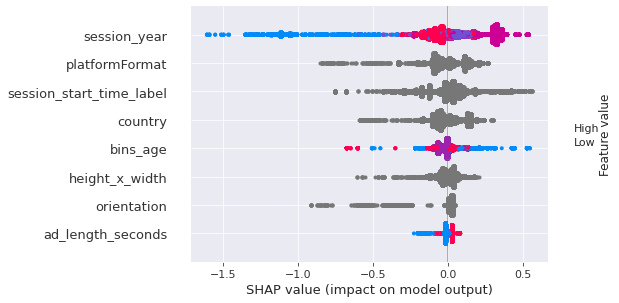

In [170]:
shap.initjs()
##Class 1 
shap.summary_plot(shap_values, Xdata_train.values, feature_names = Xdata_train.columns)



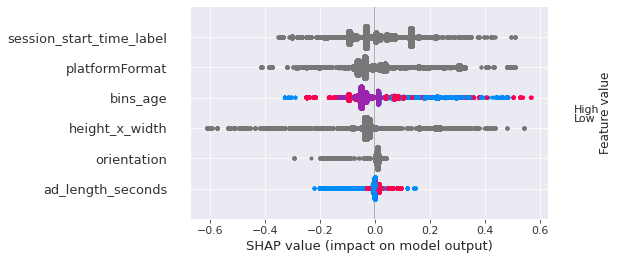

In [344]:
shap.initjs()
##Class 1 
shap.summary_plot(shap_values[1], Xdata_train.values, feature_names = Xdata_train.columns)



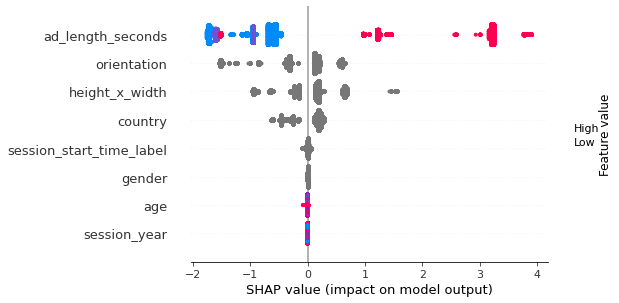

In [177]:
shap.initjs()
##Class 1 
shap.summary_plot(shap_values[2], Xdata_train.values, feature_names = Xdata_train.columns)



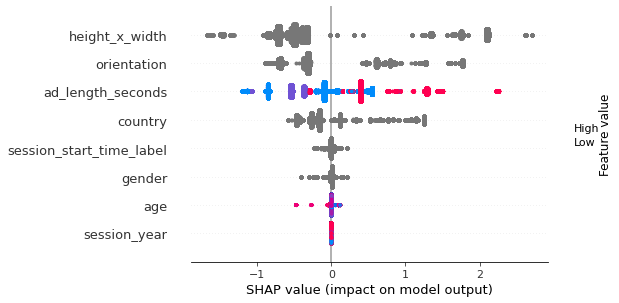

In [178]:
## Class 2
shap.summary_plot(shap_values[3], Xdata_train.values, feature_names = Xdata_train.columns)




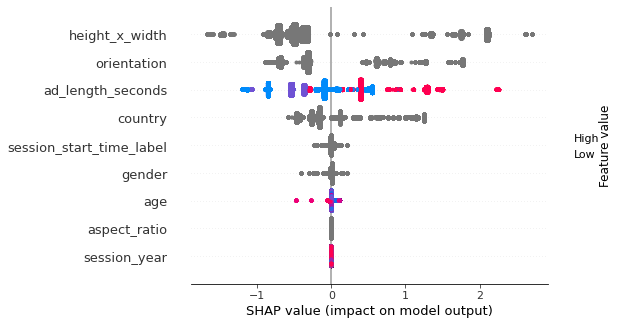

In [44]:
## Class 3
shap.summary_plot(shap_values[4], Xdata_train.values, feature_names = Xdata_train.columns)




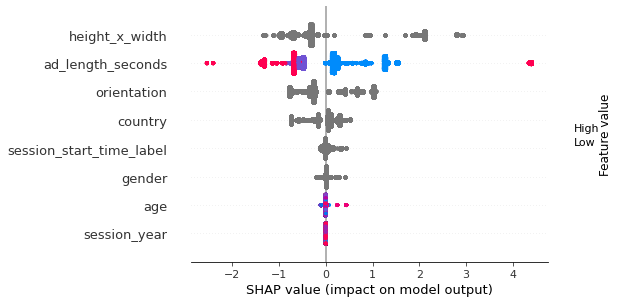

In [179]:
## Class 4
shap.summary_plot(shap_values[4], Xdata_train.values, feature_names = Xdata_train.columns)




In [171]:
#class_names = ['15secs', '20secs', '30secs', 'stream', 'others']

class_names = ['0-2 secs', '2+ secs']


/home/ec2-user/anaconda3/envs/python3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



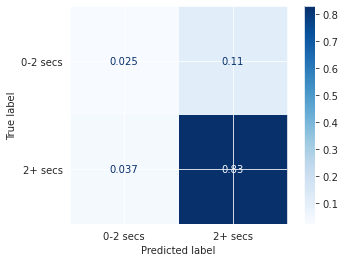

In [172]:
disp = plot_confusion_matrix(model, Xdata_val, Ydata_val, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='horizontal', normalize = 'all')

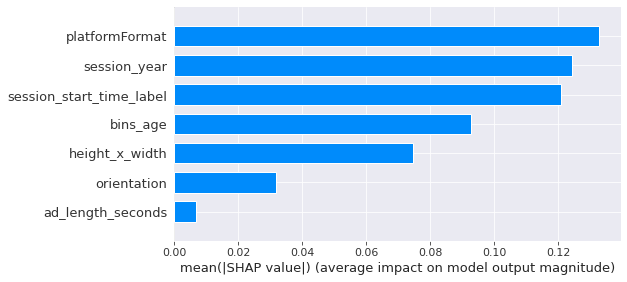

In [114]:
shap.summary_plot(shap_values, Xdata_train.values, plot_type="bar", class_names= class_names, feature_names = Xdata_train.columns)

In [1]:
#import required modules
#import shutil


In [ ]:
#shutil.make_archive('catboost_info_active_attentive_seconds', format='zip')


In [ ]:
#shutil.make_archive('catboost_info_attention_score_avg', format='zip')




In [ ]:
#shutil.make_archive('catboost_info_max_continuous_attentive_seconds', format='zip')
#

In [ ]:
#shutil.make_archive('catboost_info_passive_attentive_seconds', format='zip')


In [ ]:
#shutil.make_archive('catboost_info_Platformformat_multiclass', format='zip')